In [1]:
%pip install gurobipy
import numpy as np
import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [2]:
rnd = np.random
rnd.seed(51)

In [3]:
n = 5  # number of clients
f = 2  # number of charging stations
num_points = n + f + 1

# Generate random coordinates for xc and yc
xc = np.random.rand(num_points) * 200
yc = np.random.rand(num_points) * 100

# Randomly select f points from the generated points
selected_indices = np.random.choice(num_points, f, replace=False)
selected_xc = xc[selected_indices]
selected_yc = yc[selected_indices]

# Remove the selected points from xc and yc
xc = np.delete(xc, selected_indices)
yc = np.delete(yc, selected_indices)
xc=np.append(xc,xc[0])
yc=np.append(yc,yc[0])

print(xc)
print(yc)
num_of_copies = 2
# Append copies of each selected point after the first n points
for i in range(f):
    for _ in range(num_of_copies):
        xc = np.append(xc, selected_xc[i])
        yc = np.append(yc, selected_yc[i])
print("Remaining xc:", xc)
print("Remaining yc:", yc)

[135.1462831    8.94243644  68.66073451 189.86756133  31.53403375
  77.59459248 135.1462831 ]
[58.99936765 48.77957913 17.4343386  24.98314091 41.02479861  4.7725783
 58.99936765]
Remaining xc: [135.1462831    8.94243644  68.66073451 189.86756133  31.53403375
  77.59459248 135.1462831  128.8039454  128.8039454   56.84259975
  56.84259975]
Remaining yc: [58.99936765 48.77957913 17.4343386  24.98314091 41.02479861  4.7725783
 58.99936765 21.81825612 21.81825612 64.67455442 64.67455442]


11


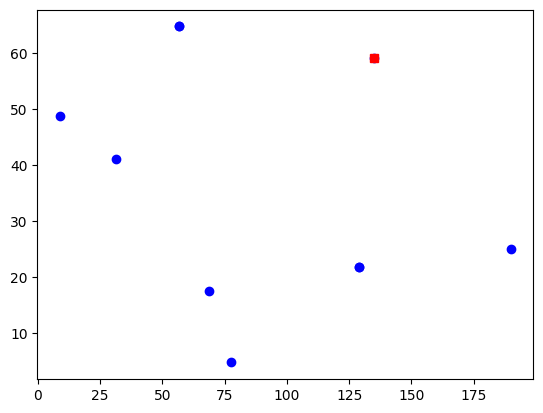

In [4]:
plt.plot(xc[0], yc[0], c='r', marker='s')
plt.scatter(xc[1:], yc[1:], c='b')
print(len(xc))

In [5]:
I = [i for i in range(1, n+1)] #Number of nodes/locations
F = [i for i in range(n+2,n+2+num_of_copies*f)]
N = I + F
F_depo = [0] + F
I_depo = [0] + N
I_dest = N + [n+1]
I_depo_dest = N + [0] + [n+1]
print(I_dest)
num_of_vehicles = 5
K = [i for i in range(1,num_of_vehicles+1)]
A = [(i, j, k) for i in I_depo for j in I_dest for k in K if i != j] 
dist = [(i, j) for i in I_depo for j in I_dest if i != j] 
total_with_vehicles = [(i,k) for i in I_depo_dest for k in K]
print("aman")
print(K)
c = {(i, j): np.hypot(xc[i]-xc[j], yc[i]-yc[j]) for i, j in dist} 
C = 15                
q = {i: rnd.randint(1, 10) for i in N}
# for _ in range()
Q = 500
H = 50 
max_value = max(c.values())
Q = H*1.1*max_value
print(I)
print(F)
print(N)
print(q)
q[0]=0
for i in range(n+1,n+2+num_of_copies*f):
    q[i] = 0
print(q)
print(Q)
Q=10000
print(n+1)

[1, 2, 3, 4, 5, 7, 8, 9, 10, 6]
aman
[1, 2, 3, 4, 5]
[1, 2, 3, 4, 5]
[7, 8, 9, 10]
[1, 2, 3, 4, 5, 7, 8, 9, 10]
{1: 6, 2: 3, 3: 4, 4: 8, 5: 8, 7: 4, 8: 9, 9: 3, 10: 6}
{1: 6, 2: 3, 3: 4, 4: 8, 5: 8, 7: 0, 8: 0, 9: 0, 10: 0, 0: 0, 6: 0}
10036.583987911585
6


In [6]:
from gurobipy import Model, GRB, quicksum

model = Model('ECVRP')
x = model.addVars(A, vtype=GRB.BINARY, name='x')
u = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0,ub=C, name='u')
y = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS,lb=0, ub=Q, name='y')
h = model.addVars(total_with_vehicles, vtype=GRB.CONTINUOUS, name='h')

# for i in I_depo_dest:
#     h[i] = H + u[i] / C

model.modelSense = GRB.MINIMIZE
# u[0].setAttr(GRB.Attr.LB, C)
# u[0].setAttr(GRB.Attr.UB, C)
# y[0].setAttr(GRB.Attr.LB, Q)
# y[0].setAttr(GRB.Attr.UB, Q)

model.setObjective(quicksum(x[i, j, k]*c[i, j] for i, j, k in A))
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) == 1 for i in I), name='outgoing')
model.addConstrs((quicksum(x[i, j, k] for k in K for j in I_dest if i!=j) <= 1 for i in F), name='charging_outgoing')
model.addConstrs((quicksum(x[0, j, k] for j in N) <= 1 for k in K), name='charging_outgoing')
model.addConstrs((quicksum(x[i, j, k] for i in I_depo if i!=j)-quicksum(x[j,i,k] for i in I_dest if i!=j) == 0 for j in N for k in K), name='blockage')
model.addConstrs((u[j,k]<=u[i,k]-q[i]*x[i,j,k]+ C*(1-x[i,j,k]) for i in I_depo for j in I_dest if i!=j for k in K), name='weight_transfer')
# model.addConstrs((u[i]>=0 for i in I_dest), name='weight_lower_bound')
# model.addConstrs((u[0]<=C), name='weight_upper_bound')
Temp = 323
theta = 0.1
H = H*0.8 + Temp*(theta)
model.addConstrs(h[i,k] == H + u[i,k] / C for i in I_depo_dest for k in K)
model.addConstrs((y[j,k]<=y[i,k]-h[i,k]*c[i,j]*x[i,j,k]+Q*(1-x[i,j,k]) for i in I for j in  I_dest  if i!=j for k in K), name = 'charge_left')
model.addConstrs((y[j,k]<=Q-h[i,k]*c[i,j]*x[i,j,k] for i in F_depo for j in I_dest  if i!=j for k in K), name='after leaving from charging station')
# model.addConstrs((y[i]>=0 for i in I_dest), name='charge_lower_bound')
# model.addConstrs((y[i]<=Q for i in N), name='charge_upper_bound')
# model.addConstr(u[0]==C, name='Specifying_constant_weight')
model.addConstrs((u[0,k]==C for k in K), name='Specifying_constant_weight')
model.addConstrs((y[0,k]==Q for k in K), name='Specifying_constant_charge')
model.Params.MIPGap = 0.1
model.Params.TimeLimit = 500  # seconds
model.optimize()
# optimal path -  active paths


Set parameter Username
Academic license - for non-commercial use only - expires 2024-11-07
Set parameter MIPGap to value 0.1
Set parameter TimeLimit to value 500
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: Intel(R) Core(TM) i7-6500U CPU @ 2.50GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 579 rows, 620 columns and 2745 nonzeros
Model fingerprint: 0x9662f1ca
Model has 455 quadratic constraints
Variable types: 165 continuous, 455 integer (455 binary)
Coefficient statistics:
  Matrix range     [7e-02, 2e+01]
  QMatrix range    [2e+01, 2e+02]
  QLMatrix range   [1e+00, 1e+04]
  Objective range  [2e+01, 2e+02]
  Bounds range     [1e+00, 1e+04]
  RHS range        [1e+00, 1e+04]
  QRHS range       [1e+04, 1e+04]
Presolve removed 140 rows and 125 columns
Presolve time: 0.04s
Presolved: 1109 rows, 830 columns, 5605 nonzeros
Variable types: 405 continuous, 425 integer (400 binary)

R

In [7]:
# model.computeIIS()
model.write("model4.lp")

In [8]:
for var_name in u:
    u_var = u[var_name]
    print(f"{var_name} = {u_var.X}")

(1, 1) = 0.0
(1, 2) = 0.0
(1, 3) = 0.0
(1, 4) = 14.999999999999773
(1, 5) = 0.0
(2, 1) = 15.000000000000227
(2, 2) = 0.0
(2, 3) = 0.0
(2, 4) = 15.0
(2, 5) = 0.0
(3, 1) = 4.000000000000227
(3, 2) = 15.0
(3, 3) = 0.0
(3, 4) = 15.0
(3, 5) = 0.0
(4, 1) = 15.0
(4, 2) = 15.0
(4, 3) = 0.0
(4, 4) = 8.999999999999773
(4, 5) = 0.0
(5, 1) = 12.000000000000227
(5, 2) = 2.2737367544323206e-13
(5, 3) = 15.0
(5, 4) = 15.0
(5, 5) = 15.0
(7, 1) = 15.000000000000227
(7, 2) = 0.0
(7, 3) = 2.2737367544323206e-13
(7, 4) = 15.0
(7, 5) = 0.0
(8, 1) = 4.000000000000227
(8, 2) = 0.0
(8, 3) = 0.0
(8, 4) = 0.0
(8, 5) = 15.0
(9, 1) = 0.0
(9, 2) = 0.0
(9, 3) = 0.0
(9, 4) = 14.999999999999773
(9, 5) = 0.0
(10, 1) = 0.0
(10, 2) = 0.0
(10, 3) = 0.0
(10, 4) = 0.9999999999997726
(10, 5) = 0.0
(0, 1) = 15.0
(0, 2) = 15.0
(0, 3) = 15.0
(0, 4) = 15.0
(0, 5) = 15.0
(6, 1) = 0.0
(6, 2) = 0.0
(6, 3) = 0.0
(6, 4) = 0.0
(6, 5) = 0.0


In [9]:
for var_name in h:
    h_var = h[var_name]
    print(f"{var_name} = {h_var.X}")

(1, 1) = 72.30000000000001
(1, 2) = 72.30000000000001
(1, 3) = 72.30000000000001
(1, 4) = 73.3
(1, 5) = 72.30000000000001
(2, 1) = 73.30000000000003
(2, 2) = 72.30000000000001
(2, 3) = 72.30000000000001
(2, 4) = 73.30000000000001
(2, 5) = 72.30000000000001
(3, 1) = 72.56666666666669
(3, 2) = 73.30000000000001
(3, 3) = 72.30000000000001
(3, 4) = 73.30000000000001
(3, 5) = 72.30000000000001
(4, 1) = 73.30000000000001
(4, 2) = 73.30000000000001
(4, 3) = 72.30000000000001
(4, 4) = 72.9
(4, 5) = 72.30000000000001
(5, 1) = 73.10000000000004
(5, 2) = 72.30000000000003
(5, 3) = 73.30000000000001
(5, 4) = 73.30000000000001
(5, 5) = 73.30000000000001
(7, 1) = 73.30000000000003
(7, 2) = 72.30000000000001
(7, 3) = 72.30000000000003
(7, 4) = 73.30000000000001
(7, 5) = 72.30000000000001
(8, 1) = 72.56666666666669
(8, 2) = 72.30000000000001
(8, 3) = 72.30000000000001
(8, 4) = 72.30000000000001
(8, 5) = 73.30000000000001
(9, 1) = 72.30000000000001
(9, 2) = 72.30000000000001
(9, 3) = 72.30000000000001


In [10]:
for var_name in y:
    y_var = y[var_name]
    print(f"{var_name} = {y_var.X}")

(1, 1) = 0.0
(1, 2) = 0.0
(1, 3) = 0.0
(1, 4) = 4275.962701700687
(1, 5) = 10000.0
(2, 1) = 5579.806667316062
(2, 2) = 0.0
(2, 3) = 0.0
(2, 4) = 0.0
(2, 5) = 10000.0
(3, 1) = 4722.887981860649
(3, 2) = 4722.887981860649
(3, 3) = 4722.887981860649
(3, 4) = 4722.887981860649
(3, 5) = 4722.887981860649
(4, 1) = 10000.0
(4, 2) = 0.0
(4, 3) = 0.0
(4, 4) = 2525.155889444278
(4, 5) = 10000.0
(5, 1) = 4443.931002512619
(5, 2) = 0.0
(5, 3) = 1.1368683772161603e-13
(5, 4) = 10000.0
(5, 5) = 10000.0
(7, 1) = 0.0
(7, 2) = 0.0
(7, 3) = 0.0
(7, 4) = 0.0
(7, 5) = 0.0
(8, 1) = 0.0
(8, 2) = 0.0
(8, 3) = 0.0
(8, 4) = 0.0
(8, 5) = 0.0
(9, 1) = 0.0
(9, 2) = 0.0
(9, 3) = 0.0
(9, 4) = 0.0
(9, 5) = 0.0
(10, 1) = 0.0
(10, 2) = 0.0
(10, 3) = 0.0
(10, 4) = 0.0
(10, 5) = 0.0
(0, 1) = 10000.0
(0, 2) = 10000.0
(0, 3) = 10000.0
(0, 4) = 10000.0
(0, 5) = 10000.0
(6, 1) = 0.0
(6, 2) = 0.0
(6, 3) = 0.0
(6, 4) = 0.0
(6, 5) = 0.0


[(0, 7, 1), (0, 9, 4), (1, 4, 4), (2, 5, 1), (3, 6, 1), (4, 10, 4), (5, 8, 1), (7, 2, 1), (8, 3, 1), (9, 1, 4), (10, 6, 4)]


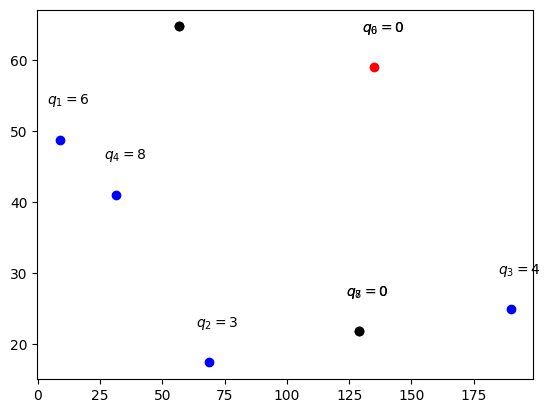

In [11]:
active_arcs = [a for a in A if x[a].x > 0.99]

print(active_arcs)
plt.scatter(xc[1:n], yc[1:n], c = 'b')
plt.scatter(xc[n+2:],yc[n+2:], c= 'black')
plt.scatter(xc[0], yc[0], c='r')

# plt.title('Optimal route with %s as max weight'%C, fontsize = 20)
for i in I_depo_dest:
    plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-5, yc[i]+5))
    # plt.annotate('$q_%d = %d$' % (i,y[i]), (xc[i]-5, yc[i]+5))
# number_of_vehicles=0
# for i,j,k in active_arcs:
#     if(i==0):
#        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = 'g')
plt.show()
# print(number_of_vehicles)

In [12]:
values = {}
sum=0
vehicle_dist={}
for i,j,k in active_arcs:
    sum+=(c[i,j])
    if(k not in vehicle_dist):
      vehicle_dist[k]=c[i,j]
    else:
         vehicle_dist[k]+=c[i,j]
    if i!=0:
        values[i]=(j,k)
for i in vehicle_dist.values():
     print(i)
colors = ['magenta', 'green', 'red', 'yellow', 'cyan']
def rec(i, j,k,col):
        print((i,j,k))
        plt.plot([xc[i],xc[j]], [yc[i], yc[j]], c = colors[col])
        if(j==n+1):
             return
        print("aman")
        print(values[j][0])
        rec(j,values[j][0],values[j][1],col)


293.06686316845344
266.0108318200126


In [13]:
print(c[0,17])
print(c[0,6])
print(c[0,6]*51)
# print(c[0,5]*h[5].X)

KeyError: (0, 17)

[(0, 9, 5), (0, 17, 1), (0, 20, 3), (0, 24, 2), (1, 13, 3), (2, 4, 2), (3, 12, 1), (4, 11, 2), (5, 11, 5), (6, 14, 1), (7, 2, 2), (8, 10, 3), (9, 19, 5), (10, 11, 3), (12, 11, 1), (13, 8, 3), (14, 3, 1), (17, 6, 1), (19, 5, 5), (20, 1, 3), (24, 26, 2), (25, 7, 2), (26, 25, 2)]
(0, 9, 5)
aman
19
(9, 19, 5)
aman
5
(19, 5, 5)
aman
11
(5, 11, 5)
(0, 17, 1)
aman
6
(17, 6, 1)
aman
14
(6, 14, 1)
aman
3
(14, 3, 1)
aman
12
(3, 12, 1)
aman
11
(12, 11, 1)
(0, 20, 3)
aman
1
(20, 1, 3)
aman
13
(1, 13, 3)
aman
8
(13, 8, 3)
aman
10
(8, 10, 3)
aman
11
(10, 11, 3)
(0, 24, 2)
aman
26
(24, 26, 2)
aman
25
(26, 25, 2)
aman
7
(25, 7, 2)
aman
2
(7, 2, 2)
aman
4
(2, 4, 2)
aman
11
(4, 11, 2)


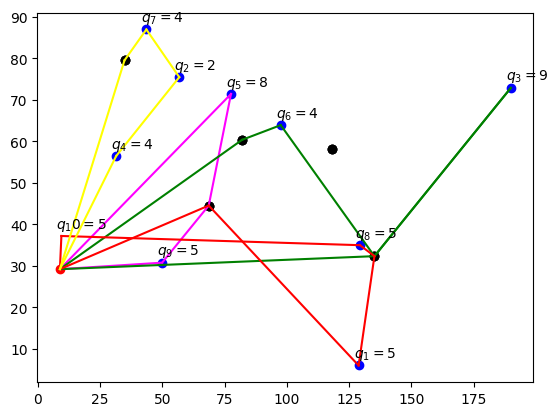

In [ ]:
active_arcs = [a for a in A if x[a].x > 0.99]

print(active_arcs)
plt.scatter(xc[1:n], yc[1:n], c = 'b')
plt.scatter(xc[n+2:],yc[n+2:], c= 'black')
plt.scatter(xc[0], yc[0], c='r')

# plt.title('Optimal route with %s as max weight'%C, fontsize = 20)
visited = []
for i in I:
    if(xc[i] not in visited):
      plt.annotate('$q_%d = %d$' % (i,q[i]), (xc[i]-2, yc[i]+2))
      visited.append(xc[i])
    # plt.annotate('$q_%d = %d$' % (i,y[i]), (xc[i]-5, yc[i]+5))
# import random

# number_of_vehicles=0
col=0
# print(type(active_arcs))
for i,j,k in active_arcs:
    if(i==0):
        rec(i,j,k,col)
        col+=1
plt.show()
# print(number_of_vehicles)